# Real-World Data Processing with RNN, LSTM, and GRU in PyTorch


In [1]:
!pip install torch
!pip install kagglehub

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for grpclib: filename=grpclib-0.4.7-py3-none-any.whl size=76255 sha256=b1293e9ff770d1d13900c704d9960e1c34bd7446a309aa50da4dbe9fabe643dc
  Stored in directory: c:\users\prathyusha ragav a\appdata\local\pip\cache\wheels\2f\ea\a0\8b06690b5111389e46b61f9636f4444c1304efd44918c2712c
Successfully built grpclib
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.10.0
    Uninstalling Pygments-2.10.0:
      Successfully uninstalled Pygments-2.10.0
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8
  Attempting uninstall: pyOp

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from tqdm import tqdm

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")

data_path = os.path.join(cache_path, "mryanm/luflow-network-intrusion-detection-data-set/versions/240")

if not os.path.exists(data_path):
    # Download latest version
    data_path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

# List to store dataframes
df_list = []

# Load and optimize each CSV
for year in tqdm(sorted(os.listdir(data_path))):  # Sorting for consistency
    year_path = os.path.join(data_path, year)
    if os.path.isdir(year_path):
        for month in sorted(os.listdir(year_path)):
            month_path = os.path.join(year_path, month)
            if os.path.isdir(month_path):
                for day in sorted(os.listdir(month_path)):
                    day_path = os.path.join(month_path, day)
                    if os.path.isdir(day_path):
                        for file in os.listdir(day_path):
                            if file.endswith(".csv"):
                                full_path = os.path.join(day_path, file)
                                data = pd.read_csv(full_path)

                                # Extract date info safely
                                y, m, d = map(int, file.split(".")[:3])
                                data["Year"] = y
                                data["Month"] = m
                                data["Day"] = d

                                # Reduce memory usage BEFORE adding to list
                                data = reduce_mem_usage(data, verbose=False)
                                df_list.append(data)

# Final concatenation
df = pd.concat(df_list, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 4.59G/4.59G [08:26<00:00, 9.74MB/s]

Extracting files...



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:01<00:00, 75.33s/it]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206556547 entries, 0 to 206556546
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float32
 1   bytes_in       int32  
 2   bytes_out      int32  
 3   dest_ip        int32  
 4   dest_port      float64
 5   entropy        float16
 6   num_pkts_out   int16  
 7   num_pkts_in    int16  
 8   proto          int16  
 9   src_ip         int32  
 10  src_port       float64
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float32
 14  label          object 
 15  duration       float16
 16  Year           int16  
 17  Month          int8   
 18  Day            int8   
dtypes: float16(2), float32(2), float64(2), int16(4), int32(4), int64(2), int8(2), object(1)
memory usage: 15.0+ GB


In [6]:
# Load a real-world dataset (Stock Prices Example)
# The original URL was returning a 404 error (Not Found)
# Updated to a working URL for the AAPL stock data
url = "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv"
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# Rename the 'AAPL.Close' column to 'close' to match the original code
df = df.rename(columns={'AAPL.Close': 'close'})

# Select 'close' price for modeling
data = df[['close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Function to create sequences for RNNs
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 30  # Use past 30 days to predict the next day
X, y = create_sequences(data, seq_length)

# Reshape X to match PyTorch format (batch_size, sequence_length, features)
X = X.view(X.shape[0], seq_length, 1)

C:\Users\PRATHY~1\AppData\Local\Temp/ipykernel_20996/1903800550.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


## Define RNN, LSTM, and GRU Models

In [7]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out


## Training the Models and Recording Loss

In [8]:

def train_model(model, X, y, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    return losses

# Initialize models
rnn_model = RNNModel(input_size=1, hidden_size=64, output_size=1)
lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1)
gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)

# Train models and record loss
rnn_losses = train_model(rnn_model, X, y)
lstm_losses = train_model(lstm_model, X, y)
gru_losses = train_model(gru_model, X, y)


Epoch 0, Loss: 0.2707
Epoch 10, Loss: 0.1000
Epoch 20, Loss: 0.0234
Epoch 30, Loss: 0.0165
Epoch 40, Loss: 0.0153
Epoch 50, Loss: 0.0138
Epoch 60, Loss: 0.0130
Epoch 70, Loss: 0.0124
Epoch 80, Loss: 0.0120
Epoch 90, Loss: 0.0117
Epoch 0, Loss: 0.2484
Epoch 10, Loss: 0.2033
Epoch 20, Loss: 0.1422
Epoch 30, Loss: 0.0466
Epoch 40, Loss: 0.0334
Epoch 50, Loss: 0.0248
Epoch 60, Loss: 0.0216
Epoch 70, Loss: 0.0191
Epoch 80, Loss: 0.0173
Epoch 90, Loss: 0.0157
Epoch 0, Loss: 0.2451
Epoch 10, Loss: 0.1618
Epoch 20, Loss: 0.0892
Epoch 30, Loss: 0.0182
Epoch 40, Loss: 0.0149
Epoch 50, Loss: 0.0152
Epoch 60, Loss: 0.0130
Epoch 70, Loss: 0.0118
Epoch 80, Loss: 0.0114
Epoch 90, Loss: 0.0110


## Visualizing the Training Loss

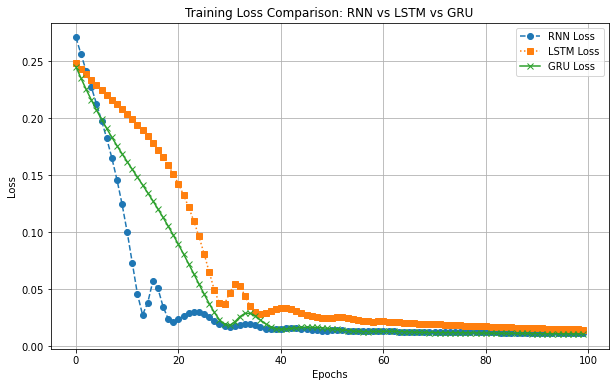

In [9]:
# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()

## Testing the Models on New Data

In [10]:
def predict(model, input_seq):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).view(1, seq_length, 1)
    with torch.no_grad():
        prediction = model(input_seq)
    return scaler.inverse_transform(prediction.numpy().reshape(-1, 1))[0][0]

# Example Test Case (Predict Next Day's Closing Price)
test_seq = data[-seq_length:].reshape(-1, 1)  # Use the last 30 days
print("RNN Prediction:", predict(rnn_model, test_seq))
print("LSTM Prediction:", predict(lstm_model, test_seq))
print("GRU Prediction:", predict(gru_model, test_seq))

RNN Prediction: 133.88306
LSTM Prediction: 132.65042
GRU Prediction: 133.92499
